In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader
from torch import nn
from tqdm import tqdm


In [48]:
device = (
    "cuda"
    if torch.cuda.is_available()

    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Supervised Learning

شایان ذکر است که تمامی کدهای این بخش با کمک آدرس زیر

https://github.com/mpezeshki/pytorch_forward_forward/blob/main/main.py

زده شده است ولی در آن تلاش بر این بوده که فقط از آن الهام بگیریم و کلاسها و توابع را خود پیاده‌سازی کنیم.

در این قسمت از کد ما دیتاست را صدا کرده و داده‌ها را با ترنسفورمهای مشهور لود می‌کنیم.

In [ ]:
def MNIST_dataset_loader(train_batch_size=30000, test_batch_size=6000):

  basic_transform  = transforms.Compose([ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)), # Define the transformation to apply to the data
                        transforms.Lambda(lambda x: x.view(-1))])

  # Load the MNIST training dataset
  train_loader = torch.utils.data.DataLoader(MNIST('./data/', train=True, download=True, transform=basic_transform), batch_size=train_batch_size, shuffle=True)
  # Load the MNIST test dataset
  test_loader = torch.utils.data.DataLoader(MNIST('./data/', train=False, download=True, transform=basic_transform), batch_size=test_batch_size, shuffle=False)

  return train_loader, test_loader

پس از لود کردن داده‌ها، برای ایجاد داده‌های منفی و مثبت از توابع زیر استفاده
میکنیم. در این توابع لیبل داده را به صورت یک بردار وان-هات در قسمتی از تصویر جایگذاری میکنیم.


In [ ]:
# For difference we replace label at last pixels of figure
def replace_label(data, label):
  new_data = data.clone()
  new_data[:, -10:-1] = 0.0
  new_data[range(new_data.shape[0]), label] = data.max()
  return new_data

def create_negative_label(data,label):
  new_data = data.clone()
  new_data[:, -10:-1] = 0.0
  rnd = torch.randint(10, size=(new_data.shape[0],))
  new_data[range(new_data.shape[0]), rnd] = data.max()
  return new_data


پس از تشکیل توابع ایجاد داده مثبت و منفی کلاس لایه‌ها را با توجه به ابعاد لایه‌های مخفی به وجود می‌آوریم. سایر توضیحات به صورت کامنت در کد وجود دارد/

در مورد لاس می‌توان گفت:
با تعریف تابع ضرر داریم، اگر خوب بودن داده‌های مثبت به بالای آستانه برود، ضرر کاهش می‌یابد و خوب بودن داده‌های منفی از آستانه پایین‌تر می‌رود.
  بنابراین منطقی است که ما چنین تابع ضرری داشته باشیم.

In [ ]:
class Layer(nn.Linear):
  def __init__(self, input_feature, output_feature, bias=True, device=None, dtype=None):
    super().__init__(input_feature, output_feature, bias, device, dtype)
    self.epochs = 1000
    self.threshold = 2.0 ## threshold for goodness
    self.relu = torch.nn.ReLU()
    self.optimizer = Adam(self.parameters(), lr = 1e-2) ## Adam was best optimizer for this proccess

  def forward(self, x): ## forward an input with one linear layer and relu activation to an output
    x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-4)
    x_matmul = torch.matmul(x_normalized, self.weight.T) + self.bias.unsqueeze(0)
    x_relu = self.relu(x_matmul)
    return x_relu

  def goodness_loss(self, pos, neg): ##  calculate loss
    loss = torch.log(1 + torch.exp(torch.cat([pos,neg]))).mean()
    return loss

  def train(self, x_pos, x_neg): ## train code with goodness option described in hw's text
    for i in range(self.epochs):
      g_pos = torch.square(self.forward(x_pos)).mean(1)
      g_neg = torch.square(self.forward(x_neg)).mean(1)

      g_loss = self.goodness_loss(self.threshold-g_pos,g_neg-self.threshold)

      self.optimizer.zero_grad()
      g_loss.backward()
      self.optimizer.step()
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()

پس از تشکیل لایه، نیاز داریم که یک شبکه عصبی با این داده‌ها ساخته و بوسیه لایه‌های ایجاد شده و روش گودنس، آموزش داده شود.
سایر توضیحات در کامنت‌ها موجود است.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self,hidden_dims=[], input_dim=784):
      super().__init__()
      self.num_layer = len(hidden_dims)
      self.layer = []
      for i in range(self.num_layer):
        if i == 0:
          self.layer.append(Layer(input_dim, hidden_dims[i]))
        else:
          self.layer.append(Layer(hidden_dims[i-1], hidden_dims[i]))
    def predict(self, x): # predict data label
      g_per_label = []

      for label in range(10): # for each label, we create one dataset that a part of the image replaced by one-hot vector of label
        g_calculated = []
        h_x = replace_label(x,label)

        for i in range(self.num_layer):
          h_x = self.layer[i].forward(h_x)
          g_calculated.append(torch.square(h_x).mean(1))

        g_per_label.append(sum(g_calculated).unsqueeze(1))
      g_per_label = torch.cat(g_per_label, 1)
      return g_per_label.argmax(1)

    def train(self, data_pos, data_neg):
      trained_pos_data = data_pos.clone()
      trained_neg_data = data_neg.clone()
      for i in range(self.num_layer):
        trained_pos_data, trained_neg_data = self.layer[i].train(trained_pos_data, trained_neg_data)

حال که شبکه عصبی ما به طور کامل ساخته شده، داده‌های لود شده را آموزش می‌دهیم و سپس درصد دقت را گزارش میکنیم.

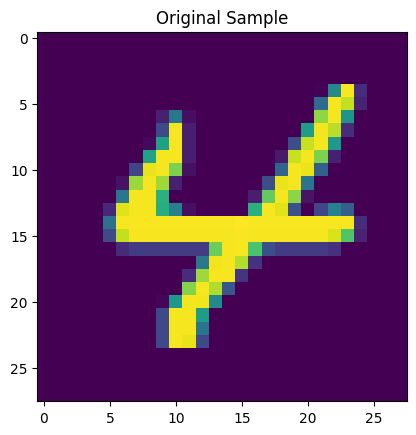

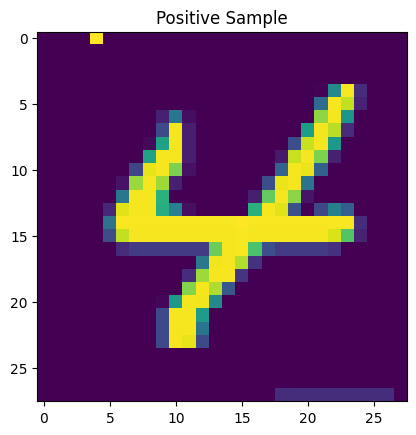

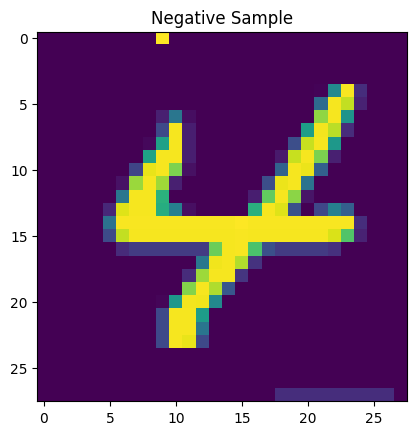

In [ ]:
## Loading Data
train_dataloader, test_dataloader = MNIST_dataset_loader()
x_train, y_train = next(iter(train_dataloader))
x_test, y_test = next(iter(test_dataloader))

## Creating Network
FF_NN = NeuralNetwork(hidden_dims=[500, 400])
x_pos = replace_label(x_train, y_train)
x_neg = create_negative_label(x_train, y_train)


## Plot the Original Sample
plt.title("Original Sample")
plt.imshow(x_train[10].reshape(28,28))
plt.show()

## Plot the Positive Sample
plt.title("Positive Sample")
plt.imshow(x_pos[10].reshape(28,28))
plt.show()

## Plot the Negative Input
plt.title("Negative Sample")
plt.imshow(x_neg[10].reshape(28,28))
plt.show()

## Train Dataset
FF_NN.train(x_pos, x_neg)


In [ ]:
print('Train Acc: ',(FF_NN.predict(x_train).eq(y_train).float().mean().item())*100,'%')
print('Test Acc: ',(FF_NN.predict(x_test).eq(y_test).float().mean().item())*100,'%')

Train Acc:  88.59666585922241 %
Test Acc:  87.05000281333923 %


### Unsupervised Learning

In [87]:
import numpy as np
import cv2
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
import os


In [88]:
def MNIST_dataset_loader(train_batch_size=30000, test_batch_size=6000):

  basic_transform  = transforms.Compose([ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # Define the transformation to apply to the data
                        ,transforms.Lambda(lambda x: x.view(-1))])


  # Load the MNIST training dataset
  train_loader = torch.utils.data.DataLoader(MNIST('./data/', train=True, download=True, transform=basic_transform), batch_size=train_batch_size, shuffle=True)
  # Load the MNIST test dataset
  test_loader = torch.utils.data.DataLoader(MNIST('./data/', train=False, download=True, transform=basic_transform), batch_size=test_batch_size, shuffle=False)

  return train_loader, test_loader

In [89]:
def create_mask(image_shape, iter_number=10):
  mask = np.random.randint(0, 2, image_shape).astype(np.float32)
  blur_filter_horizontal = np.array([[1/4, 1/2, 1/4]])
  blur_filter_vertical = blur_filter_horizontal.T
  for i in range(iter_number):
    mask = cv2.filter2D(mask, -1, blur_filter_horizontal)
    mask = cv2.filter2D(mask, -1, blur_filter_vertical)
  mask1 = np.where(mask > 0.5, 1, 0)
  mask2 = 1 - mask1
  return torch.tensor(mask1) ,  torch.tensor(mask2)


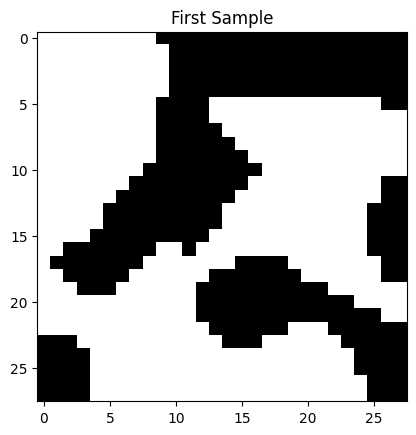

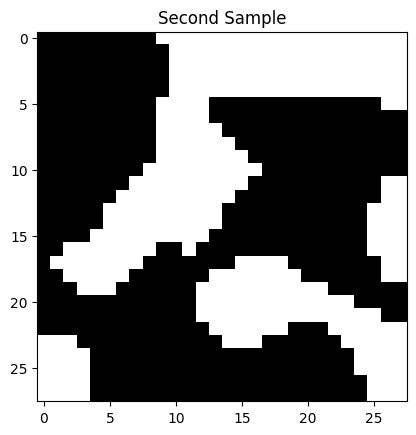

In [90]:
mask1, mask2 = create_mask((28,28))
## Plot First Sample
plt.title("First Sample")
plt.imshow(mask1 ,cmap='gray')
plt.show()
## Plot Second Sample
plt.title("Second Sample")
plt.imshow(mask2 ,cmap='gray')
plt.show()

In [91]:
## Loading Data
train_dataloader, test_dataloader = MNIST_dataset_loader()
x_train, y_train = next(iter(train_dataloader))
x_test, y_test = next(iter(test_dataloader))


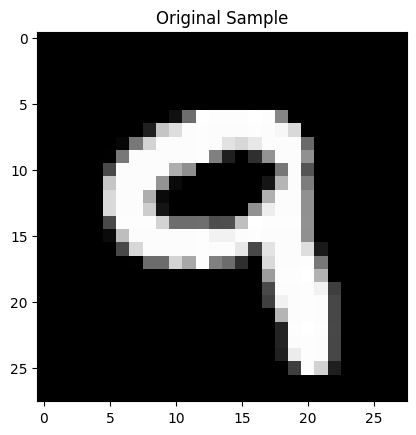

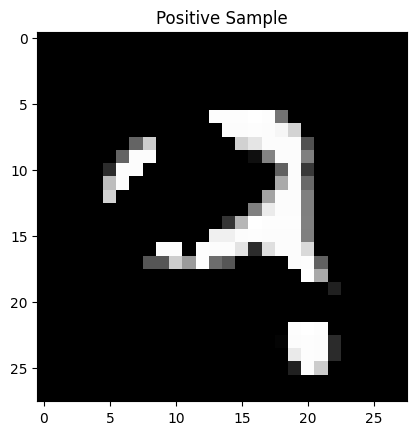

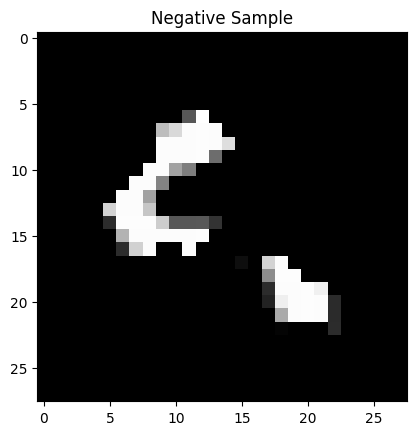

In [92]:
image1 = x_train[10].view(28,28) * mask1
image1[image1<1e-2] = 0
image2 = x_train[10].view(28,28) * mask2
image2[image2<1e-2] = 0

## Plot the Original Sample
plt.title("Original Sample")
plt.imshow(x_train[10].view(28,28), cmap='gray')
plt.show()

## Plot the Positive Sample
plt.title("Positive Sample")
plt.imshow(image1, cmap='gray')
plt.show()

## Plot the Negative Input
plt.title("Negative Sample")
plt.imshow(image2, cmap='gray')
plt.show()

In [93]:
def create_negative_data(data):
  data_len = data.shape[0]
  new_data = data.clone()
  new_data = new_data.reshape(data_len,28,28)
  for i in range(data_len):
    image1 = new_data[i]
    rnd = np.random.randint(data_len)
    image2 = new_data[rnd]
    mask1,mask2 = create_mask((28,28))
    image1 =  image1 * mask1
    image2 = image2 * mask2
    new_data[i] = image1 + image1
  new_data = new_data.reshape(data_len,784)
    # hybrid_data[row] = hybrid_data_.view(-1)
  return new_data


In [94]:
class Layer_US(nn.Linear):
  def __init__(self, input_feature, output_feature, bias=True, device=None, dtype=None):
    super().__init__(input_feature, output_feature, bias, device, dtype)
    self.epochs = 10
    self.threshold = 2.0 ## threshold for goodness
    self.relu = torch.nn.ReLU()
    self.optimizer = Adam(self.parameters(), lr = 1e-2) ## Adam was best optimizer for this proccess

  def forward(self, x): ## forward an input with one linear layer and relu activation to an output
    x_normalized = x / (x.norm(2, 1, keepdim=True) + 1e-4)
    x_matmul = torch.matmul(x_normalized, self.weight.T) + self.bias.unsqueeze(0)
    x_relu = self.relu(x_matmul)
    return x_relu

  def goodness_loss(self, pos, neg): ##  calculate loss
    loss = torch.log(1 + torch.exp(torch.cat([pos,neg]))).mean()
    return loss

  def train(self, x_pos, x_neg): ## train code with goodness option described in hw's text
    for i in range(self.epochs):
      g_pos = torch.square(self.forward(x_pos)).mean(1)
      g_neg = torch.square(self.forward(x_neg)).mean(1)

      g_loss = self.goodness_loss(self.threshold-g_pos,g_neg-self.threshold)

      self.optimizer.zero_grad()
      g_loss.backward()
      self.optimizer.step()
    return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [95]:
class NeuralNetwork_US(nn.Module):
    def __init__(self,hidden_dims=[], input_dim=784):
      super().__init__()
      self.num_layer = len(hidden_dims)
      self.layer = []
      for i in range(self.num_layer):
        if i == 0:
          self.layer.append(Layer_US(input_dim, hidden_dims[i]))
        else:
          self.layer.append(Layer_US(hidden_dims[i-1], hidden_dims[i]))
    def predict(self, x): # predict data label
      g_pos = x.clone
      g_list = []

      for i in range(self.num_layer):
        g_pos = self.layer[i].forward(g_pos)
        g_list.append(g_pos)

      g_out = torch.cat(g_list, -1)
      return g_out

    def train(self, data_pos, data_neg):
      trained_pos_data = data_pos.clone()
      trained_neg_data = data_neg.clone()
      for i in range(self.num_layer):
        trained_pos_data, trained_neg_data = self.layer[i].train(trained_pos_data, trained_neg_data)

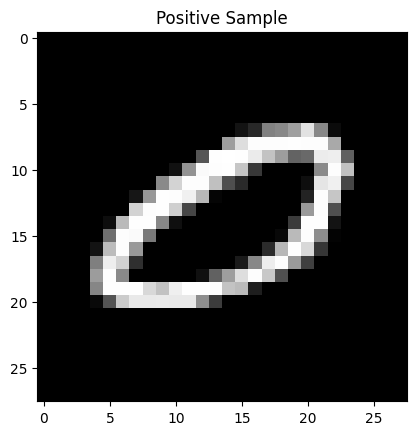

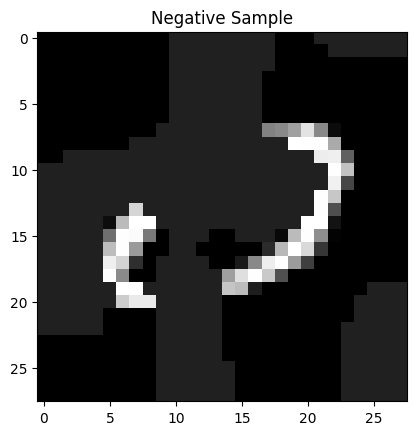

In [102]:
## Creating Network
FF_US_net = NeuralNetwork_US(hidden_dims=[500, 500])
x_pos = x_train
x_neg = create_negative_data(x_train)

## Plot the Positive Sample
plt.title("Positive Sample")
plt.imshow(x_pos[1].view(28,28), cmap='gray')
plt.show()

## Plot the Positive Sample
plt.title("Negative Sample")
plt.imshow(x_neg[1].view(28,28), cmap='gray')
plt.show()

In [100]:
FF_US_net.train(x_pos, x_neg)